In [1]:
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import pickle as pkl

%matplotlib inline

/jet/var/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/jet/var/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/jet/var/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/jet/var/python/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: P

1.10.0


In [2]:
# Functions for scoring predictions

def dn(val):
    
    return ((1 + val)*(y_max - y_min) / 2) + y_min

def calc_RMSE(y_pred, y):
    
    return np.sqrt(np.mean(np.square(y_pred.ravel() - y.ravel())))
                   
def calc_NLL(y_pred, y, y_std):
                   
    return np.mean(0.5*((((y_pred.ravel() - y.ravel())**2)/((y_std.ravel()**2)) + np.log(y_std.ravel()**2) + np.log(2*np.pi))))

def area_calc(df):
    # Adds an area per cell for use in area weighting
    x = df['x']
    y = df['y']
    z = df['z']

    lats = (180/np.pi) * np.arcsin(df['z'] / 2)
    lons = (180/np.pi) * np.arctan2(df['x'] / 2, df['y'] / 2)

    num_lons = len(set(np.round(lons,2)))
    num_lats = len(set(np.round(lats,2)))
    res_lat = 178/num_lats
    res_lon = 360/num_lons

    lat_upper_bound = lats + res_lat/2
    lat_lower_bound = lats - res_lat/2

    area = 2 * np.pi * (np.abs(np.sin(np.deg2rad(lat_upper_bound)) - np.sin(np.deg2rad(lat_lower_bound)))) / num_lons

    return area / (4 * np.pi)

def recube(in_array):

    lat_len = 64
    lon_len = 128
    time_len = 31 * 12

    output = np.zeros([time_len, lat_len, lon_len])

    for t in range(time_len):
        output[t,:,:] = in_array[lat_len * lon_len * (t): lat_len * lon_len * (t+1)].reshape([lat_len, lon_len])
    
    return output


def awRMSE(y_pred, y, area_weights):
    
    y_pred = dn(y_pred)
    y = dn(y)
    
    area_tot = np.sum(area_weights)
    
    SE = np.square(y_pred.ravel() - y.ravel())
    
    awMSE = np.nansum(area_weights * SE) / area_tot
    RawMSE = np.sqrt(awMSE)
    
    return RawMSE


def report_on_percentiles(y, y_pred, y_std):

    n = len(y.ravel())

    n1 = np.sum(np.abs(y_pred.ravel() - y.ravel()) <= y_std.ravel() * 1)
    n2 = np.sum(np.abs(y_pred.ravel() - y.ravel()) <= y_std.ravel() * 2)
    n3 = np.sum(np.abs(y_pred.ravel() - y.ravel()) <= y_std.ravel() * 3)
    print('Using {} data points'.format(n))
    print('{} within 1 std'.format(100 * n1 / n))
    print('{} within 2 std'.format(100 * n2 / n))
    print('{} within 3 std'.format(100 * n3 / n))

    return

## Load data and networks

In [3]:
df = pd.read_pickle('refC1SD_MINMAX_64x128_raw.pkl')

# Apply coordinate mapping lat,lon -> x,y,z
lon = df['lon'] * np.pi / 180
lat = df['lat'] * np.pi / 180
x = np.cos(lat) * np.cos(lon)
y = np.cos(lat) * np.sin(lon)
z = np.sin(lat)

# Apply coordinate mapping month_number -> x_mon, y_mon
rads = (df['mon_num'] * 360/12) * (np.pi / 180)
x_mon = np.sin(rads)
y_mon = np.cos(rads)

# min-max scale months (months since Jan 1980)
mons_scaled = 2 * (df['mons'] - df['mons'].min())/(df['mons'].max() - df['mons'].min()) - 1

# Remove old coords and add new mapped coords from/to dataframe
df = df.drop(['lat', 'lon', 'mon_num', 'mons'], axis=1)
df['x'] = x
df['y'] = y
df['z'] = z
df['x_mon'] = x_mon
df['y_mon'] = y_mon
df['mons'] = mons_scaled

# Apply min-max scaling to each model and observations
y_min = df['obs_toz'].min()
y_max = df['obs_toz'].max()
for i in range(16): # 15 models and 1 obs
    mdl = df[df.columns[i]]
    df[df.columns[i]] = 2 * (mdl - mdl.min())/(mdl.max() - mdl.min()) - 1
    
# Apply coordinate scaling
df['x'] = df['x'] * 2
df['y'] = df['y'] * 2
df['z'] = df['z'] * 2

df['x_mon'] = df['x_mon'] * 2
df['y_mon'] = df['y_mon'] * 2
df['mons'] = df['mons'] * 1.0

cols_to_drop = ['has_obs', 'train_mask', 'test_mask', 'interp_mask', 'extrap_mask']
# Maintain shuffling with seed
df_train = df[df['train_mask']].drop(cols_to_drop, axis=1)
df_test = df[df['test_mask']].drop(cols_to_drop, axis=1)
df_interp = df[df['interp_mask']].drop(cols_to_drop, axis=1)
df_extrap = df[df['extrap_mask']].drop(cols_to_drop, axis=1)
n_obs = np.sum(df['has_obs'].values)

print('Training on {:.1f}%'.format(100 * len(df_train)/n_obs))
print('Testing on {:.1f}%'.format(100 * len(df_test)/n_obs))
print('Validation (interpolation) on {:.1f}%'.format(100 * len(df_interp)/n_obs))
print('Validation (extrapolation) on {:.1f}%'.format(100 * len(df_extrap)/n_obs))

# In sample training
X_train = df_train.drop(['obs_toz'],axis=1).values
y_train = df_train['obs_toz'].values.reshape(-1,1)

# The in sample testing - this is not used for training
X_test = df_test.drop(['obs_toz'],axis=1).values
y_test = df_test['obs_toz'].values.reshape(-1,1)

# For all time
X_at = df.drop(['obs_toz'],axis=1).drop(cols_to_drop, axis=1).values
y_at = df.drop(cols_to_drop, axis=1)['obs_toz'].values.reshape(-1,1)

# Define masks
interp_mask = df['interp_mask'].values
train_mask = df['train_mask'].values 

# Calculate areas for area weighted RMSE
area_at = area_calc(df).values
area_train = area_calc(df_train)

Training on 77.3%
Testing on 3.6%
Validation (interpolation) on 8.2%
Validation (extrapolation) on 10.8%


In [4]:
# NN set up
tf.reset_default_graph()

# There is now no bias node in the bias layer
# Bias mean is assumed 0
bias_std = 0.03

# prior on the noise 
noise_mean = 0.015
noise_std = 0.002

num_models = 15
# hyperparameters
n = X_train.shape[0]
x_dim = X_train.shape[1]
alpha_dim = x_dim - num_models
y_dim = y_train.shape[1]

n_ensembles = 65
hidden_size = 500

# NN class
class NN():
    def __init__(self, x_dim, y_dim, hidden_size, w1, b1, w2, b2, w3, wn, learning_rate, model_bias_from_layer):
        # setting up as for a usual NN
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # set up NN
        self.inputs = tf.placeholder(tf.float32, [None, x_dim], name='inputs')
        self.modelpred = self.inputs[:, :num_models]
        self.spacetime = self.inputs[:, num_models: num_models + alpha_dim]
        self.area_weights = self.inputs[:, -1]
        self.y_target = tf.placeholder(tf.float32, [None, y_dim], name='target')
        
        self.layer_1_w = tf.layers.Dense(hidden_size, activation=tf.nn.tanh,
                                         kernel_initializer=tf.initializers.constant(w1),
                                         bias_initializer=tf.initializers.constant(b1))
        self.layer_1 = self.layer_1_w.apply(self.spacetime)
        self.layer_2_w = tf.layers.Dense(num_models, activation=None,
                                         kernel_initializer=tf.initializers.constant(w2),
                                         bias_initializer=tf.initializers.constant(b2))
        self.layer_2 = self.layer_2_w.apply(self.layer_1)

        self.model_coeff = tf.nn.softmax(self.layer_2)

        self.modelbias_w = tf.layers.Dense(y_dim, activation=None, use_bias=False,
                                           kernel_initializer=tf.initializers.constant(w3))
        if model_bias_from_layer == 1:
            self.modelbias = self.modelbias_w.apply(self.layer_1)
        elif model_bias_from_layer == 2:
            self.modelbias = self.modelbias_w.apply(self.layer_2)
            
        ### Line not right. Have added, axis=1 into the reduce sum, to make the dims work and reshaped
        # self.output now has dims which are (?, )
        self.output = tf.reduce_sum(self.model_coeff * self.modelpred, axis=1) + tf.reshape(self.modelbias, [-1])
        
        self.noise_w = tf.layers.Dense(self.y_dim, activation=None, use_bias=False,
                                       kernel_initializer=tf.initializers.constant(wn))
        
        self.noise_pred = self.noise_w.apply(self.layer_1)
        self.noise_sq = tf.square(self.noise_pred + noise_mean)[:,0] + 1e-6 


        return

    def w_init(self, sess):
        '''regularise around initialised parameters'''
        w1, b1, w2, b2, w3, wn = self.get_weights(sess)

        # get initial params
        self.w1_init, self.b1_init, self.w2_init, self.b2_init, self.w3_init, self.wn_init = w1, b1, w2, b2, w3, wn
        
        return


    def get_weights(self, sess):
        '''method to return current params'''
        ops = [self.layer_1_w.kernel, self.layer_1_w.bias, self.layer_2_w.kernel, self.layer_2_w.bias, self.modelbias_w.kernel, self.noise_w.kernel]
        w1, b1, w2, b2, w3, wn = sess.run(ops)
        return w1, b1, w2, b2, w3, wn

    def predict(self, x, sess):
        '''predict method'''
        feed = {self.inputs: x}
        y_pred = sess.run(self.output, feed_dict=feed)
        return y_pred
    
    def get_noise_sq(self, x, sess):
        '''get noise squared method'''
        feed = {self.inputs: x}
        noise_sq = sess.run(self.noise_sq, feed_dict=feed)
        return noise_sq

    def get_alphas(self, x, sess):
        feed = {self.inputs: x}
        alpha = sess.run(self.model_coeff, feed_dict=feed)
        return alpha
    
    def get_betas(self, x, sess):
        feed = {self.inputs: x}
        beta = sess.run(self.modelbias, feed_dict=feed)
        return beta

def fn_predict_ensemble(NNs,X_train):
    y_pred=[]
    y_pred_noise_sq=[]
    for ens in range(0,n_ensembles):
        y_pred.append(NNs[ens].predict(X_train, sess))
        y_pred_noise_sq.append(NNs[ens].get_noise_sq(X_train, sess))
    y_preds_train = np.array(y_pred)
    y_preds_noisesq_train = np.array(y_pred_noise_sq)
    y_preds_mu_train = np.mean(y_preds_train,axis=0)
    y_preds_std_train_epi = np.std(y_preds_train,axis=0)
    y_preds_std_train = np.sqrt(np.mean((y_preds_noisesq_train + np.square(y_preds_train)), axis = 0) - np.square(y_preds_mu_train)) #add predicted aleatoric noise
    return y_preds_train, y_preds_mu_train, y_preds_std_train, y_preds_std_train_epi, y_preds_noisesq_train

def get_alphas(NNs, X_train):
    alphas = []
    for ens in range(0,n_ensembles):
        alphas.append(NNs[ens].get_alphas(X_train, sess))
    return alphas


def get_betas(NNs, X_train):
    betas = []
    for ens in range(0,n_ensembles):
        betas.append(NNs[ens].get_betas(X_train, sess))
    return betas

### Initialise the NNs

Load the weights

In [5]:
save_path = 'NNweights'
files = [os.path.join(save_path, f) for f in os.listdir(save_path)]
weights = [pkl.load(open(f, 'rb')) for f in files]

Check weights are not the same

In [6]:
w_check = []
for i in weights:
    w_check.append(i[0][0][0])

In [7]:
if (len(set(w_check)) != n_ensembles):
    print('Same weights')

In [8]:
NNs=[]

sess = tf.Session()

# loop to initialise all ensemble members
for ens in range(0,n_ensembles):
    weight = weights[ens]
    NNs.append(NN(x_dim, y_dim, hidden_size, weight[0], weight[1], weight[2], weight[3], weight[4], weight[5],
                  0, 1))
    # initialise only unitialized variables - stops overwriting ensembles already created
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
    NNs[ens].w_init(sess)

### Sort data for validation

In [9]:
interp_mask_cube = np.array(recube(interp_mask), dtype=bool)

# Tropics
TRO_mask_cube = interp_mask_cube.copy()
trop_idxs = np.where(np.mean(interp_mask_cube[:,21:44,:], axis=(1,2)) > 0.95)[0]
for t in range(TRO_mask_cube.shape[0]):
    if t not in trop_idxs:
        TRO_mask_cube[t] = np.zeros(TRO_mask_cube.shape[1:], dtype=bool)
    else:
        temp_mask = TRO_mask_cube[t]
        temp_mask[:21, :] = np.zeros([21, TRO_mask_cube.shape[2]], dtype=bool)
        temp_mask[44:, :] = np.zeros([20, TRO_mask_cube.shape[2]], dtype=bool)
        TRO_mask_cube[t] = temp_mask
        
# Satellite tracks
SAT_mask_cube = interp_mask_cube.copy()
sat_idxs = np.where((np.mean(interp_mask_cube[:,21:44,:], axis=(1,2)) < 0.95) & (np.mean(interp_mask_cube[:,21:44,:], axis=(1,2)) > 0.35))[0]
for t in range(SAT_mask_cube.shape[0]):
    if t not in sat_idxs:
        SAT_mask_cube[t] = np.zeros(SAT_mask_cube.shape[1:], dtype=bool)
    else:
        temp_mask = SAT_mask_cube[t]
        temp_mask[:21, :] = np.zeros([21, SAT_mask_cube.shape[2]], dtype=bool)
        temp_mask[43:, :] = np.zeros([21, SAT_mask_cube.shape[2]], dtype=bool)
        SAT_mask_cube[t] = temp_mask

# Small features
SP_idxs = np.where(np.mean(interp_mask_cube[:,:10], axis=(1,2)) > 0.5)[0]
NP_idxs = np.where(np.mean(interp_mask_cube[:,-10:], axis=(1,2)) > 0.5)[0]
SF_mask_cube = interp_mask_cube.copy()
for t in trop_idxs:
    SF_mask_cube[t,21:44] = np.zeros([23, SF_mask_cube.shape[2]], dtype=bool)
for t in sat_idxs:
    SF_mask_cube[t,20:43] = np.zeros([23, SF_mask_cube.shape[2]], dtype=bool)
for t in NP_idxs:
    SF_mask_cube[t,54:] = np.zeros([10, SF_mask_cube.shape[2]], dtype=bool)
for t in SP_idxs:
    SF_mask_cube[t,:10] = np.zeros([10, SF_mask_cube.shape[2]], dtype=bool)
    
# Southern polar cap
SP_mask_cube = interp_mask_cube.copy()
for t in range(SP_mask_cube.shape[0]):
    if t not in SP_idxs:
        SP_mask_cube[t] = np.zeros(SP_mask_cube.shape[1:], dtype=bool)
    if t in SP_idxs:
        SP_mask_cube[t,10:] = np.zeros([54, SP_mask_cube.shape[2]], dtype=bool)

# Northern polar cap
NP_mask_cube = interp_mask_cube.copy()
for t in range(NP_mask_cube.shape[0]):
    if t not in NP_idxs:
        NP_mask_cube[t] = np.zeros(NP_mask_cube.shape[1:], dtype=bool)
    if t in NP_idxs:
        NP_mask_cube[t,:54] = np.zeros([54, NP_mask_cube.shape[2]], dtype=bool)

# Temporal extrapolation
TE_mask_cube = np.array(recube(df['extrap_mask'].values), dtype=bool)

# Area and true value for each extrapolation or interpolation region
y_NP = recube(y_at)[NP_mask_cube]
a_NP = recube(area_at)[NP_mask_cube]
y_SP = recube(y_at)[SP_mask_cube]
a_SP = recube(area_at)[SP_mask_cube]
y_TE = recube(y_at)[TE_mask_cube]
a_TE = recube(area_at)[TE_mask_cube]
y_TRO = recube(y_at)[TRO_mask_cube]
a_TRO = recube(area_at)[TRO_mask_cube]
y_SAT = recube(y_at)[SAT_mask_cube]
a_SAT = recube(area_at)[SAT_mask_cube]
y_SF = recube(y_at)[SF_mask_cube]
a_SF = recube(area_at)[SF_mask_cube]

# Predictions

In [10]:
y_preds_at, y_preds_mu_at, y_preds_std_at,  y_preds_std_at_epi, y_preds_noisesq_at= fn_predict_ensemble(NNs,X_at)

In [11]:
y_preds = recube(y_preds_mu_at)
print('NP awRMSE: {}'.format(awRMSE(y_preds[NP_mask_cube], y_NP, a_NP)))
print('SP awRMSE: {}'.format(awRMSE(y_preds[SP_mask_cube], y_SP, a_SP)))
print('TE awRMSE: {}'.format(awRMSE(y_preds[TE_mask_cube], y_TE, a_TE)))
print('TRO awRMSE: {}'.format(awRMSE(y_preds[TRO_mask_cube], y_TRO, a_TRO)))
print('SAT awRMSE: {}'.format(awRMSE(y_preds[SAT_mask_cube], y_SAT, a_SAT)))
print('SF awRMSE: {}'.format(awRMSE(y_preds[SF_mask_cube], y_SF, a_SF)))

NP awRMSE: 4.683272494444894
SP awRMSE: 6.613603498930464
TE awRMSE: 4.390015703236745
TRO awRMSE: 2.7171957776203772
SAT awRMSE: 2.1440050667744766
SF awRMSE: 3.1941805823223626


In [12]:
std = recube(y_preds_std_at)

### Uncertainty quantification

North pole

In [13]:
report_on_percentiles(y_NP, y_preds[NP_mask_cube], std[NP_mask_cube])

Using 26122 data points
56.16338718321721 within 1 std
87.01477681647653 within 2 std
96.96807288875277 within 3 std


South pole

In [14]:
report_on_percentiles(y_SP, y_preds[SP_mask_cube], std[SP_mask_cube])

Using 26119 data points
62.23821738963973 within 1 std
93.9277920287913 within 2 std
99.02369922278801 within 3 std


Temporal extrapolation

In [15]:
report_on_percentiles(y_TE, y_preds[TE_mask_cube], std[TE_mask_cube])

Using 252461 data points
60.52103097112029 within 1 std
92.19047694495387 within 2 std
99.06124114219622 within 3 std


Tropics

In [16]:
report_on_percentiles(y_TRO, y_preds[TRO_mask_cube], std[TRO_mask_cube])

Using 70590 data points
64.10823062756765 within 1 std
91.76370590735232 within 2 std
98.51962034282477 within 3 std


Satellite tracks

In [17]:
report_on_percentiles(y_SAT, y_preds[SAT_mask_cube], std[SAT_mask_cube])

Using 60660 data points
76.18364655456644 within 1 std
98.15199472469502 within 2 std
99.89614243323442 within 3 std


Small features

In [18]:
report_on_percentiles(y_SF, y_preds[SF_mask_cube], std[SF_mask_cube])

Using 6124 data points
75.7184846505552 within 1 std
97.35467015022861 within 2 std
99.33050293925538 within 3 std


### Model Coefficients (alphas)

In [19]:
alphas = np.array(get_alphas(NNs, X_at))

In [20]:
alpha = np.mean(alphas, axis=0)

In [21]:
pkl.dump(alpha, open('alpha.pkl', 'wb'))

Average in time

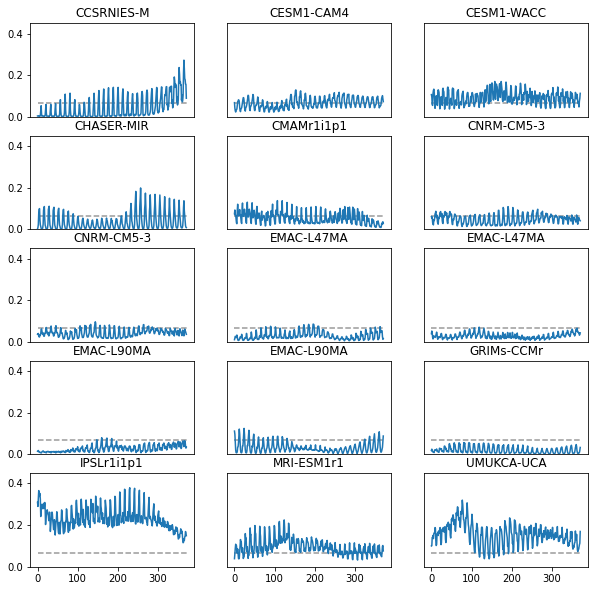

In [22]:
plt.figure(figsize=(10,10))
for i in range(num_models):
    a = alphas[:,:,i]
    plt.subplot(5,3, i + 1)
    plt.plot([0,372], [1/15,1/15], '--', color='black', alpha=0.4)
    plt.plot(np.mean(recube(np.mean(a, axis=0)), axis=(1,2)))
    plt.title(df.columns[i][:10])
    
    plt.ylim([0,0.45])
    if i <12:
        plt.xticks([], [])
    if i % 3 != 0:
        plt.yticks([], [])
plt.show()

Average seasonailty

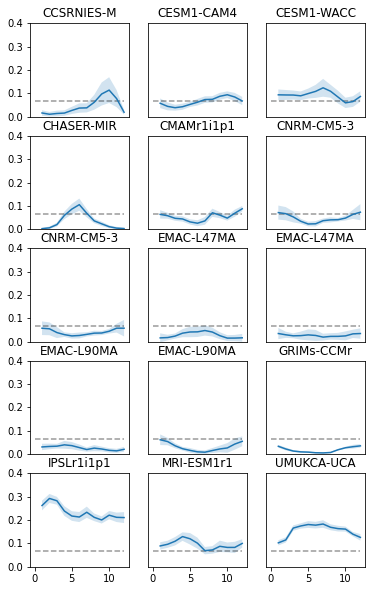

In [23]:
plt.figure(figsize=(6,10))
for i in range(num_models):
    a = alphas[:,:,i]
    a_mean = np.mean(np.mean(recube(np.mean(a, axis=0)), axis=(1,2)).reshape(-1, 12), axis=0)
    # find std across ensemble
    ens_alphas = np.zeros([12 , alphas.shape[0]])
    for j in range(alphas.shape[0]):
        ens_alphas[:, j] = np.mean(np.mean(recube(a[j]), axis=(1,2)).reshape(-1, 12), axis=0)
    a_std = np.std(ens_alphas, axis=1)
    plt.subplot(5,3, i + 1)
    plt.plot([0,12], [1/15,1/15], '--', color='black', alpha=0.4)
    plt.fill_between(np.arange(12) + 1, a_mean - a_std, a_mean + a_std, alpha=0.2)
    plt.plot(np.arange(12) + 1, a_mean)
    plt.title(df.columns[i][:10])
    plt.ylim([0,0.4])
    if i <12:
        plt.xticks([], [])
    if i % 3 != 0:
        plt.yticks([], [])

plt.show()

Average in space

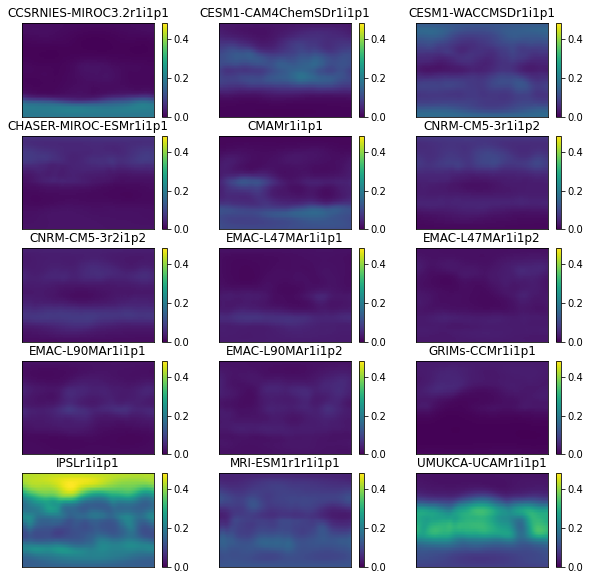

In [25]:
plt.figure(figsize=(10,10))
vmax = 0
vmin = 0
for i in range(num_models):
    if np.max(np.mean(recube(alpha[:,i]), axis=0)) > vmax:
        vmax = np.max(np.mean(recube(alpha[:,i]), axis=0))

for i in range(num_models):
    plt.subplot(5,3, i + 1)
    plt.pcolormesh(np.mean(recube(alpha[:,i]), axis=0), vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(df.columns[i])

plt.show()

### Model bias

In [26]:
betas = np.array(get_betas(NNs, X_at))
beta = np.mean(betas, axis=0)

In [27]:
pkl.dump(beta, open('beta.pkl', 'wb'))

In time

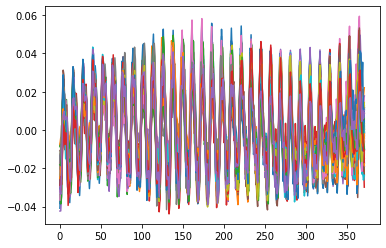

In [28]:
plt.figure()
for b in betas:
    plt.plot(np.mean(recube(b.ravel()), axis=(1,2)))
plt.show()

In space

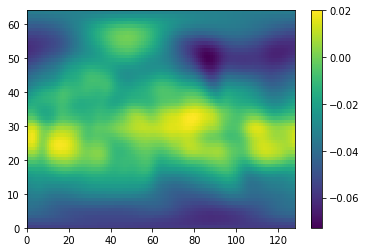

In [29]:
plt.figure()
plt.pcolormesh(recube(beta)[0])
plt.colorbar()
plt.show()

### Noise predictions

In [30]:
aletoric_noise = []

for NN in NNs:
    feed_b = {}
    feed_b[NN.inputs] = X_at
    feed_b[NN.y_target] = y_at
    noise_sq = sess.run(NN.noise_sq, feed_dict=feed_b)
    aletoric_noise.append(noise_sq)

Average aleatoric noise

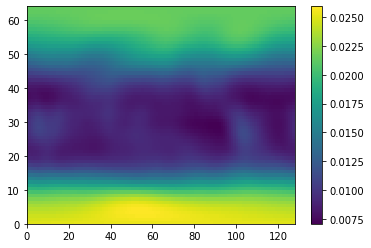

In [31]:
plt.figure()
plt.pcolormesh(np.mean(recube(np.sqrt(np.mean(np.array(aletoric_noise), axis=0))), axis=0))
plt.colorbar()
plt.show()

In [32]:
a_n = recube(np.sqrt(np.mean(np.array(aletoric_noise), axis=0)))

In [33]:
pkl.dump(a_n, open('aleatoric_noise.pkl', 'wb'))

Average error prediction in months and latitude

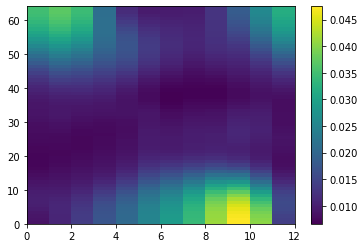

In [34]:
err_pred = np.zeros((12,64))

for i in range(12):
    err_pred[i, :] = np.mean(recube(np.sqrt(np.mean(np.array(aletoric_noise), axis=0)))[i::12], axis=(0,2))
    
plt.figure()
plt.pcolormesh(err_pred.T)
plt.colorbar()
plt.show()

### Epistemic ucertainty

In [36]:
epi = recube(y_preds_std_at_epi)

In [37]:
pkl.dump(epi, open('epi.pkl', 'wb'))

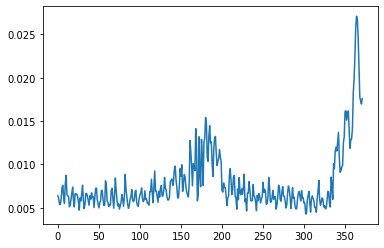

In [39]:
plt.plot(np.mean(epi, axis=(1,2)))